In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle

## load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)
    
with open('data/continent_to_reviews.pkl', 'rb') as f:
    continent_to_reviews = pickle.load(f)

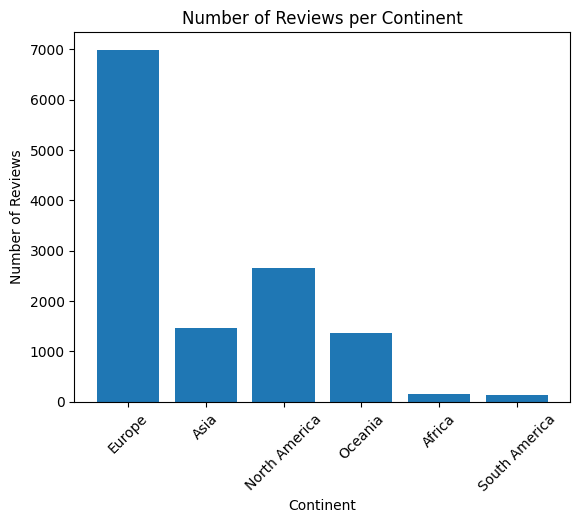

["Flew on SAA from Jo'burg to Abu Dhabi and we were over the airport when the captain announced we were 12th in the queue for landing with a resultant 40 minute circle before landing. Once in the immigration hall in terminal 1 another 70 minute queue. It is obvious the airport cannot cope with the increased traffic and the passenger experience becomes very poor. In the past my wife and I used Abu Dhabi rather than Dubai but I am having a serious rethink.", 'I was shocked to experience the enormous waiting time to clear immigration - it took me three hours of standing in a slow-moving line of exhausted people. That is not what I had expected of a place that wants to attract tourism. Of course I will continue using the airport because it is a hub for if one wants to travel from Southern Africa to Asia but in future I will try my utmost to avoid this. Beyond belief.', 'Clear signage - was transferring from T1 to T3. Long walk but easy to find way and not too crowded. Security lines short 

In [3]:
## make a bar plot of the number of reviews per continent
continents = list(continent_to_reviews.keys())
num_reviews = [len(continent_to_reviews[continent]) for continent in continents]
plt.bar(continents, num_reviews)
plt.ylabel('Number of Reviews')
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.title('Number of Reviews per Continent')
plt.savefig('images/num_reviews_per_continent.png', dpi=300, bbox_inches='tight')
plt.show()

print(continent_to_reviews["Africa"])

In [62]:
from gcmap import GCMapper, Gradient
## make G undirected
G_undirect = G.to_undirected(reciprocal=True)
source_lon, source_lat, destination_lon, destination_lat, nb_flights = [], [], [], [], []
edges = G_undirect.edges(data=True)
for u, v, data in edges:
    if u != v:
        source_lon.append(IATA[u]['longitude'])
        source_lat.append(IATA[u]['latitude'])
        destination_lon.append(IATA[v]['longitude'])
        destination_lat.append(IATA[v]['latitude'])
        nb_flights.append(data['weight'])
        
grad = Gradient(((0, 0, 0, 0), (0.5, 204, 0, 153), (1, 255, 204, 230)))
gcm = GCMapper(cols=grad, height=2000, width=4000)
gcm.set_data(source_lon, source_lat, destination_lon, destination_lat, nb_flights)
img = gcm.draw()
img.save('images/flightmap.png')

  6%|▌         | 1000/18110 [00:01<00:17, 998.09it/s]


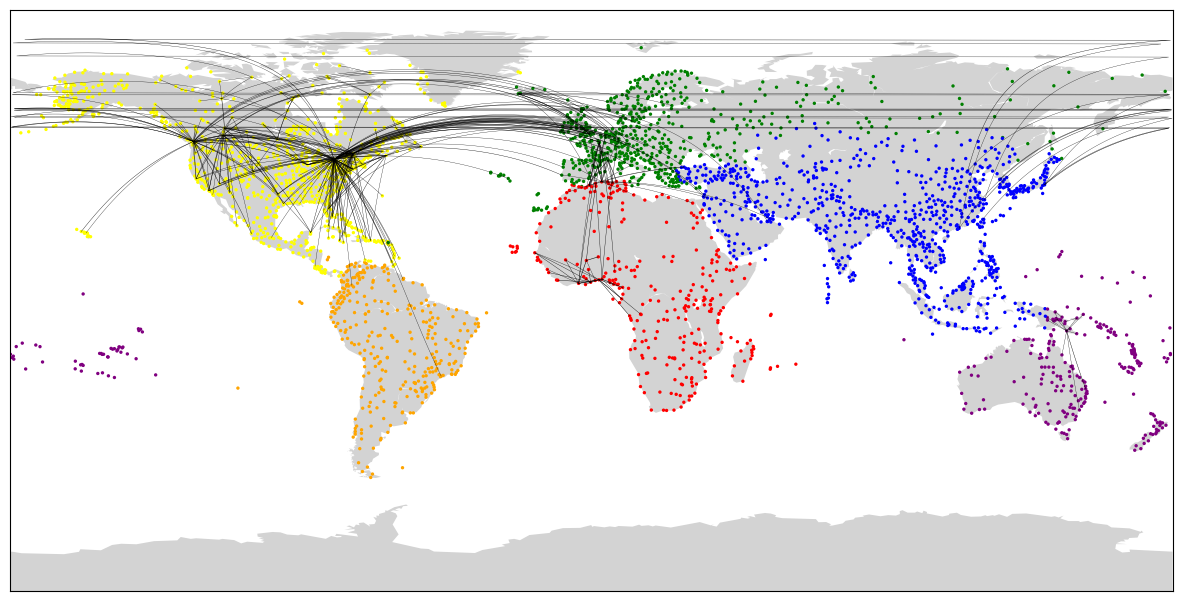

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import PowerNorm
from matplotlib.colorbar import ColorbarBase
from tqdm import tqdm

## create a basemap
fig, ax = plt.subplots(figsize=(15, 10))
resolution = "c"
# resolution = "i"
m = Basemap(lon_0=0, resolution='c')
## make the land lightgreen and the oceans darkblue
m.fillcontinents(color="lightgrey", lake_color="white")

continent_to_color = {'Africa': 'red', 'Asia': 'blue', 'Europe': 'green', 'North America': 'yellow', 'Oceania': 'purple', 'South America': 'orange'}

## plot the nodes
lons = [IATA[node]['longitude'] for node in G_undirect.nodes()]
lats = [IATA[node]['latitude'] for node in G_undirect.nodes()]
colors = [continent_to_color[IATA[node]['continent']] for node in G_undirect.nodes()]
x, y = m(lons, lats)
m.scatter(x, y, color=colors, s=2)

weights = [data['weight'] for _, _, data in G_undirect.edges(data=True)]
norm = PowerNorm(0.3, np.min(weights), np.max(weights))
cmap = plt.cm.viridis

for i, (u, v, data) in enumerate(tqdm(G_undirect.edges(data=True))):
    if u != v:
        x1, y1 = IATA[u]['longitude'], IATA[u]['latitude']
        x2, y2 = IATA[v]['longitude'], IATA[v]['latitude']
        weight = data['weight']
        if abs(x2 - x1) > 0.5 and abs(y2 - y1) > 0.5:
            m.drawgreatcircle(x1, y1, x2, y2, linewidth=0.5 * norm(weight), alpha = 0.3, color="black")
        
        
## save the plot
plt.savefig('images/flightmap_basemap.png', dpi=300, bbox_inches='tight')

In [3]:
import netwulf as nw
nw.visualize(G)

(None, None)

In [70]:
norm(20)

1.0

Nodes with the highest degree:  [('FRA', 477), ('CDG', 470), ('AMS', 463), ('IST', 455), ('ATL', 433), ('ORD', 409), ('PEK', 408), ('MUC', 380), ('DME', 376), ('DFW', 372)]


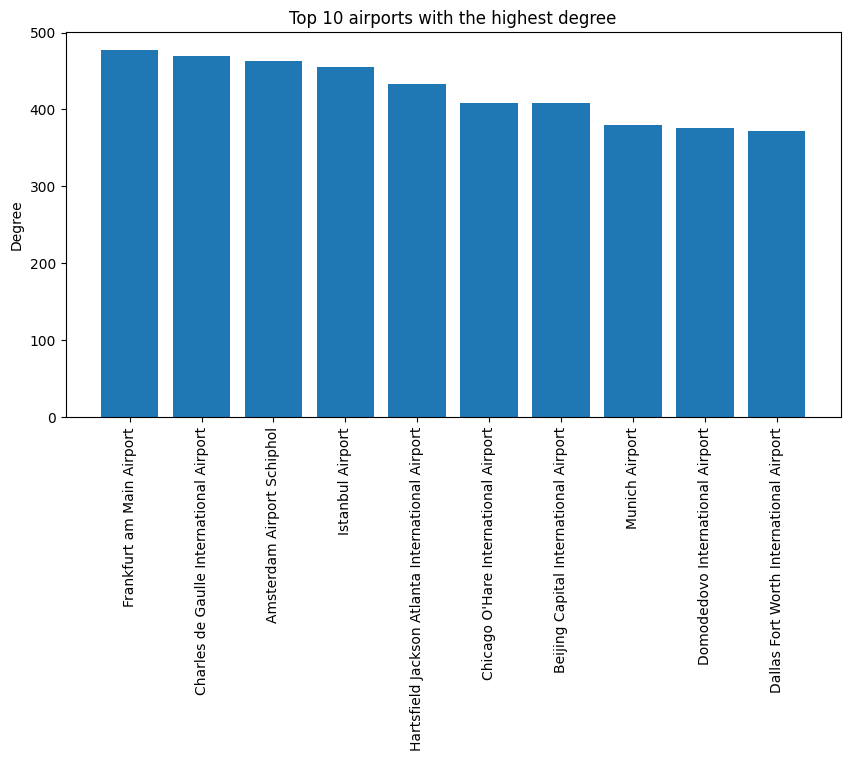

Edges with the highest weight:  [(('ORD', 'ATL'), 20), (('ATL', 'ORD'), 19), (('HKT', 'BKK'), 13), (('ORD', 'MSY'), 13), (('LHR', 'JFK'), 12), (('AUH', 'MCT'), 12), (('HKG', 'BKK'), 12), (('CAN', 'HGH'), 12), (('MIA', 'ATL'), 12), (('ATL', 'MIA'), 12)]


In [29]:
## find nodes with the highest degree
## make a bar plot of the top 10
## on the x-axis, put the airport city name
## on the y-axis, put the degree of the airport
degrees = dict(G.degree())
sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Nodes with the highest degree: ", sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10, 5))
plt.bar([G.nodes[k]["name"] for k, v in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]],
        [v for k, v in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]])
plt.xticks(rotation=90)
plt.ylabel('Degree')
plt.title('Top 10 airports with the highest degree')
plt.savefig('images/top10_airports_degree.png', dpi=300, bbox_inches='tight')
plt.show()



## find the edges with the highest weight
weights = nx.get_edge_attributes(G, 'weight')
sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10]
print("Edges with the highest weight: ", sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])